Using kernel `conda_pytorch_latest_p36`

In [1]:
# !pip install fastai
# !pip install cloudpathlib

# Import

In [2]:
import sys
sys.path.append('../../../')

In [3]:
from pathlib import Path
import os
import random
import json
from datetime import datetime
from collections import defaultdict

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import torch
import sagemaker
from sagemaker import get_execution_role
import boto3
import torch.nn as nn
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
from fastai.text.all import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, multilabel_confusion_matrix

In [5]:
from deep.constants import *
from deep.utils import *

In [6]:
%load_ext autoreload
%autoreload 2

# Data

In [9]:
def preprocessing(df):
    df = df.copy()
    df['sectors'] = df['sectors'].apply(eval)    
    df['pillars'] = df['pillars'].apply(eval)
    df['pillars'] = df['pillars'].apply(lambda x: list(set(x)))
    df['subpillars'] = df['subpillars'].apply(eval)
    return df

In [14]:
column = 'subpillars'
classes=SUBPILLARS
text_column = 'excerpt'
merge_column = 'merge'

In [11]:
train = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.3_train.csv'))
val = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.3_val.csv'))
test = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.3_test.csv'))

In [15]:
def process_multiclass(df, train, column='pillars', classes=PILLARS):
    relevant_train = df.copy()
    relevant_train = relevant_train[relevant_train[column].apply(len) > 0]
    relevant_train[merge_column] = relevant_train.pillars + relevant_train.subpillars
    relevant_train[merge_column] = relevant_train[merge_column].apply(lambda x: ';'.join(x)) 
    
    
    relevant_train['is_valid'] = False if train else True
    
    return relevant_train
    
    

# Use fastai

In [16]:
train_df = process_multiclass(train, True, column=column, classes=classes)
test_df = process_multiclass(test, False, column=column, classes=classes)
df = pd.concat([train_df, test_df])

In [20]:
dls = TextDataLoaders.from_df(
    df,
    text_col=text_column,
    label_col=merge_column,
    label_delim=';',
    valid_col='is_valid',
    is_lm = False,    # Mention explicitly that this dataloader is meant for language model
    seq_len = 72,     # Pick a sequence length i.e. how many words to feed through the RNN at once
    bs = 64,     # Specify the batch size for the dataloader
    y_block=MultiCategoryBlock,
)
learn = text_classifier_learner(
    dls, 
    AWD_LSTM, 
    drop_mult=0.5, 
    metrics=[
        accuracy_multi, 
        RecallMulti(thresh=0.35), 
        PrecisionMulti(thresh=0.35), 
        F1ScoreMulti(thresh=0.35), 
        RocAucMulti()
    ]
)
classes = learn.dls.vocab[1]

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
learn.fine_tune(3, 0.02)

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.241613,0.235420,0.907648,0.244468,0.357179,0.246176,0.769242,02:29


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.213281,0.210538,0.915581,0.321233,0.485350,0.355466,0.834945,06:24
1,0.194528,0.194077,0.922853,0.379586,0.534336,0.403280,0.865692,06:23
2,0.183265,0.189148,0.925515,0.398446,0.534008,0.423688,0.873375,06:23


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [22]:
def get_threshold_metrics(preds, targets, num_thresholds):
    thresholds = [x/num_thresholds for x in range(num_thresholds)]

    recalls = []
    precisions = []
    f1_scores = []

    for threshold in thresholds:
        t_preds = (preds.view(-1).numpy() > threshold).astype(int)
        t_targets = targets.view(-1).numpy()
        precisions.append(precision_score(t_targets, t_preds))
        recalls.append(recall_score(t_targets, t_preds))    
        f1_scores.append(f1_score(t_targets, t_preds))        
        
    all_metrics = pd.DataFrame(
        {
            'threshold': thresholds,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('threshold', drop=True)

    return all_metrics

In [23]:
def get_best_threshold(learner, num_thresholds=20):
    train_preds, train_targets = learn.get_preds(0)
    train_metrics = get_threshold_metrics(train_preds, train_targets, num_thresholds)
    best_threshold = train_metrics.f1_score.idxmax()
    
    return best_threshold, train_metrics

In [24]:
def get_metrics(preds, targets):
    indexes = []
    recalls = []
    precisions = []
    f1_scores = []
    counts = []
    
    for i, class_ in enumerate(classes):
        class_preds = preds[:, i]
        class_targets = targets[:, i]
        
        indexes.append(class_)
        precisions.append(precision_score(class_targets, class_preds))
        recalls.append(recall_score(class_targets, class_preds))    
        f1_scores.append(f1_score(class_targets, class_preds))  
        counts.append(int(class_targets.sum()))
        
    indexes.append('all')
    precisions.append(precision_score(targets.view(-1), preds.view(-1)))
    recalls.append(recall_score(targets.view(-1), preds.view(-1)))    
    
    f1_scores.append(f1_score(targets.view(-1), preds.view(-1)))  
    counts.append(int(targets.view(-1).sum()))



    
    all_metrics = pd.DataFrame(
        {
            'class': indexes,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores,
            'counts': counts
        }
    ).set_index('class', drop=True)
    
    return all_metrics

In [25]:
def evaluate(learner, threshold):
    test_preds, test_targets = learn.get_preds(1)
    

In [26]:
best_threshold, train_metrics = get_best_threshold(learn)
print(best_threshold)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.35


In [27]:
train_metrics

,recall,precision,f1_score
threshold,,,
0.00,1.000000,0.108998,0.196570
0.05,0.953988,0.323883,0.483587
0.10,0.902230,0.415813,0.569267
0.15,0.849779,0.489798,0.621420
0.20,0.798937,0.553899,0.654226
0.25,0.755901,0.602736,0.670685
0.30,0.714940,0.643254,0.677205
0.35,0.673936,0.680583,0.677243
0.40,0.631694,0.715339,0.670920


In [28]:
test_preds, test_targets = learn.get_preds(1)
test_discrete_preds = (test_preds > best_threshold).int()
test_discrete_targets = test_targets.int()

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
test_preds

tensor([[3.5797e-03, 6.0366e-04, 3.4362e-03,  ..., 1.2056e-03, 2.6529e-04,
         1.7839e-03],
        [9.7551e-01, 9.1668e-01, 3.6971e-01,  ..., 3.5879e-04, 2.5593e-04,
         6.4742e-05],
        [8.6056e-03, 2.5875e-03, 4.6781e-03,  ..., 6.8204e-03, 3.0903e-03,
         4.1156e-03],
        ...,
        [5.3481e-02, 7.4605e-03, 4.8034e-02,  ..., 9.5153e-02, 3.2265e-02,
         6.6032e-02],
        [3.8556e-01, 2.3315e-02, 4.1353e-01,  ..., 4.5696e-02, 1.8691e-02,
         3.0039e-02],
        [2.8918e-01, 5.7855e-02, 2.5533e-01,  ..., 4.5575e-02, 2.4170e-02,
         2.4458e-02]])

In [30]:
test_targets

TensorMultiCategory([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [31]:
count = defaultdict(int)
a = test_df.pillars.apply(lambda x: x.split(';'))
for x in a:
    for y in x:
        count[y] += 1

AttributeError: 'list' object has no attribute 'split'

In [32]:
multilabel_confusion_matrix(test_discrete_preds, test_discrete_targets, samplewise=False)

array([[[5036,  305],
        [ 359,  816]],

       [[5846,   95],
        [ 196,  379]],

       [[5580,  377],
        [ 303,  256]],

       [[6265,   55],
        [  67,  129]],

       [[6507,    9],
        [   0,    0]],

       [[1591,  291],
        [1411, 3223]],

       [[6149,  248],
        [  51,   68]],

       [[3226,  432],
        [1249, 1609]],

       [[6003,  301],
        [  47,  165]],

       [[5101,  459],
        [ 256,  700]],

       [[2842,  550],
        [1203, 1921]],

       [[4964,  575],
        [ 506,  471]],

       [[5762,  501],
        [ 121,  132]],

       [[6278,  133],
        [  25,   80]],

       [[6153,  226],
        [  90,   47]],

       [[5634,  392],
        [ 184,  306]],

       [[6191,  280],
        [  22,   23]],

       [[5478,  577],
        [ 162,  299]],

       [[6438,   78],
        [   0,    0]],

       [[5542,  519],
        [ 163,  292]],

       [[6243,   72],
        [  82,  119]],

       [[6271,   60],
        [  8

In [33]:
multi_label_metrics = get_metrics(test_discrete_preds,test_discrete_targets)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
multi_label_metrics

,recall,precision,f1_score,counts
class,,,,
Capacities & Response,0.727921,0.694468,0.710801,1121
Capacities & Response->International Response,0.799578,0.659130,0.722593,474
Capacities & Response->National Response,0.404423,0.457961,0.429530,633
Capacities & Response->Number Of People Reached,0.701087,0.658163,0.678947,184
Capacities & Response->Response Gaps,0.000000,0.000000,0.000000,9
Humanitarian Conditions,0.917188,0.695511,0.791114,3514
Humanitarian Conditions->Coping Mechanisms,0.215190,0.571429,0.312644,316
Humanitarian Conditions->Living Standards,0.788339,0.562981,0.656869,2041
Humanitarian Conditions->Number Of People In Need,0.354077,0.778302,0.486726,466


<AxesSubplot:xlabel='class'>

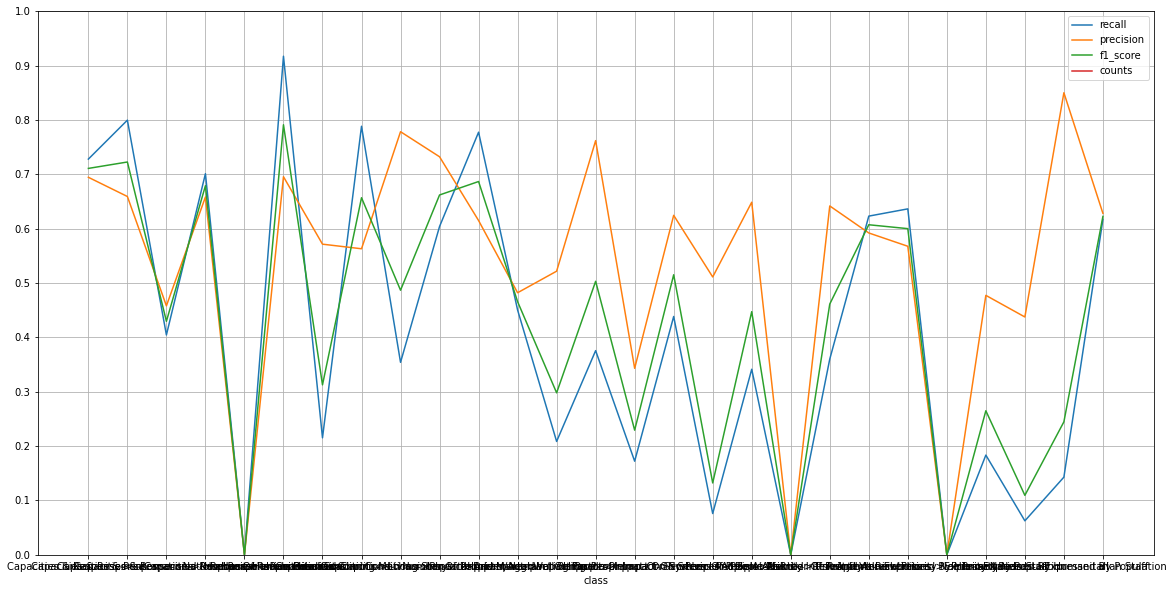

In [35]:
multi_label_metrics.plot(figsize=(20, 10), xticks=range(len(classes)+1), yticks=[x/10 for x in range(11)], ylim=(0, 1), grid=True)

In [ ]:
base = Path('/home/ec2-user/SageMaker/experiments-dfs/models/fastai/results')

In [ ]:
with open(base / 'multi_label_metrics.pickle', 'wb') as f:
    pickle.dump(multi_label_metrics, f)

# Analysis

In [ ]:
tp = test_discrete_preds
tt = test_discrete_targets

In [ ]:
test_df

In [ ]:
start = 0

In [ ]:
for sentence, sector,p, t, in zip(
    test_df.sentence_text.iloc[start:], 
    test_df.sector_ids.iloc[start:], 
    tp[start:], 
    tt[start:]
):
    if 1 or list(p) != list(t):
        print(sentence)
        t = [classes[i] for i, x in enumerate(t) if x]
        print('Expected:', ', '.join(t))
        p = [classes[i] for i, x in enumerate(p) if x]
        print('Predicted:', ', '.join(p))
    else:
        continue
    
    a = input()
    if a == 's':
        break
    